In [1]:
import numpy as np
import pandas as pd
import os
from src.utils.data import select_tomo_ids
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from keras import Sequential, Input, layers

2025-06-03 18:08:36.500098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 18:08:37.266959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-03 18:08:37.266984: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-03 18:08:37.337152: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 18:08:38.866664: W tensorflow/stream_executor/platform/de

In [2]:
def get_slice_file_path(tomogram_id, z):
    '''
    accès au chemin d'une slice en fonction de l'identifiant du tomogramme et de l'indice de la slice
    Parameters:
        tomogram_id (str): l'identifiant du tomogramme
        z (int): l'indice de la slice
    Returns:
        str: le chemin de l'image
    '''
    tomogrammes_train_dir = './data/pictures_raw/train/'
    file_name = f'slice_{str(int(z)).zfill(4)}.jpg'
    #print(f'get_slice_file_path: {tomogram_id} {z} {file_name}')
    image_path = os.path.join(tomogrammes_train_dir, tomogram_id, file_name)
    return image_path

def get_motor_coordinates(df, tomogram_id):
    '''
    Récupération des coordonnées du moteur dans le tomogramme
    Parameters:
        df (pd.Dataframe): le dataframe des données
        tomogram_id (str): l'identifiant du tomogramme
    Returns:
        tuple: les coordonnées du moteur
    '''
    df_tomogram = df[df['tomo_id'] == tomogram_id]
    x = df_tomogram['Motor_axis_2'].values[0]
    y = df_tomogram['Motor_axis_1'].values[0]
    z = df_tomogram['Motor_axis_0'].values[0]


    ############# MODIFIE !!!!!! #################
    numb_motors = df_tomogram['Number_of_motors'].values[0]
    #print(f'get_motor_coordinates: {tomogram_id} {x} {y} {z}')
    return x, y, z, numb_motors

In [3]:
df = pd.read_csv('../data/csv_raw/train_labels.csv')

ids_list = select_tomo_ids(df, number_of_motors=[1])

rows = []

for id in ids_list:
    x, y, z, numb_motors = get_motor_coordinates(df, id)
    image_path = get_slice_file_path(id, z)
    rows.append([x, y, numb_motors, image_path])

df = pd.DataFrame(rows, columns=["x", "y", "Number_of_motors", "picture_source"])
df

,x,y,Number_of_motors,picture_source
0,762.0,257.0,1,./data/pictures_raw/train/tomo_05df8a/slice_01...
1,575.0,587.0,1,./data/pictures_raw/train/tomo_0a8f05/slice_00...
2,636.0,356.0,1,./data/pictures_raw/train/tomo_0da370/slice_00...
3,585.0,295.0,1,./data/pictures_raw/train/tomo_101279/slice_01...
4,658.0,768.0,1,./data/pictures_raw/train/tomo_13484c/slice_01...
...,...,...,...,...
300,387.0,469.0,1,./data/pictures_raw/train/tomo_f78e91/slice_00...
301,115.0,642.0,1,./data/pictures_raw/train/tomo_f871ad/slice_01...
302,491.0,537.0,1,./data/pictures_raw/train/tomo_fc3c39/slice_01...
303,313.0,513.0,1,./data/pictures_raw/train/tomo_fc5ae4/slice_00...


In [4]:
# y = df.Number_of_motors

# X = []

# for source in df.picture_source:
#     best_slice_path = os.path.join(f'.{source}')

#     img = load_img(best_slice_path, color_mode='grayscale')
#     img_array = img_to_array(img) / 255

#     # append to the slice list
#     X.append(img_array)

# X = np.array(X)


X = []

for source in df.picture_source:
    best_slice_path = os.path.join(f'.{source}')

    img = load_img(best_slice_path, color_mode='grayscale', target_size=(128, 128))  # ou autre taille
    img_array = img_to_array(img) / 255.0  # shape: (128, 128, 1)

    X.append(img_array)

X = np.array(X)

In [5]:
X.shape

(305, 128, 128, 1)

In [6]:
y = df[['x', 'y']]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
y_train.shape

(195, 2)

In [18]:

def init_model_cnnlog(X):
    model = Sequential()
    model.add(Input(shape= X.shape[1:]))

    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))

    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (2, 2),
                            padding='same',
                            activation="relu"))
    model.add(layers.Conv2D(128, (2, 2),
                            padding='same',
                            activation="relu"))
    model.add(layers.Conv2D(128, (2, 2),
                            padding='same',
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256,activation= 'relu'))

    model.add(layers.Dense(10,activation= 'relu'))

    model.add(layers.Dense(2, activation='linear'))
    return model


model = init_model_cnnlog(X_train)

In [19]:
def model_compiled(model):
    model.compile(loss= 'mse',
                  optimizer = 'adam',
                  metrics=['mse'] )
    return model
model_compi = model_compiled(model)

In [ ]:


def model_train (model, X_train, y_train, batch_size=32 ,epochs=50, verbose=1):
    es = EarlyStopping(patience=5,
                       restore_best_weights=True)

    history = model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=[X_val, y_val],
                        callbacks=[es],
                        verbose=verbose)
    return history

history = model_train(model_compi, X_train, y_train)
history

Epoch 1/50
7/7 [==============================] - 3s 350ms/step - loss: 210399.7344 - mse: 210399.7344 - val_loss: 74269.2422 - val_mse: 74269.2422
Epoch 2/50
1/7 [===>..........................] - ETA: 1s - loss: 52830.5312 - mse: 52830.5312

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set_ylim(0,10)
    ax[1].set_title('mse')
    ax[1].plot(history.epoch, history.history["mse"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_mse"], label="Validation ,mse")
    ax[1].set_ylim(0,10)
    ax[0].legend()
    ax[1].legend()

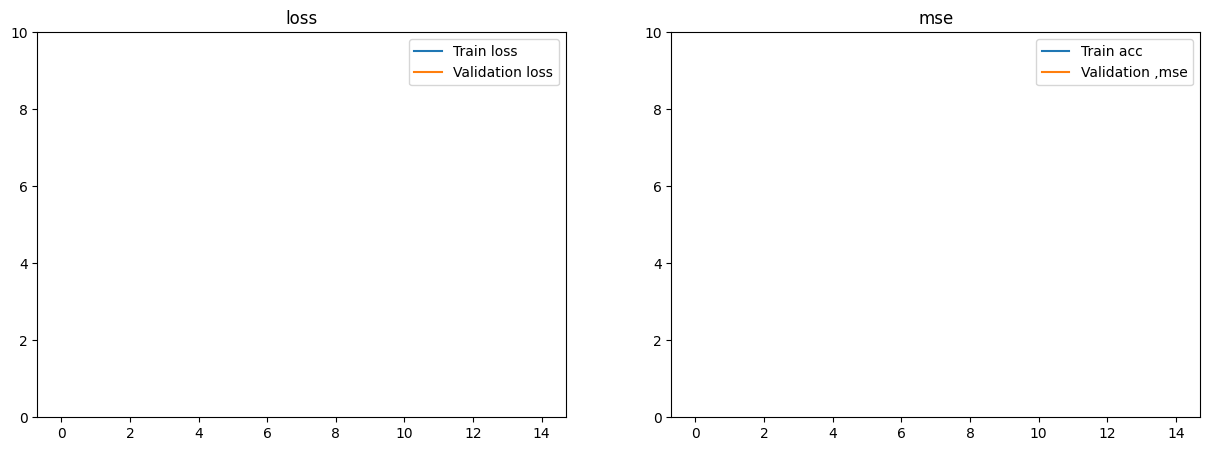

In [20]:
plot_history(history)

In [21]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5,
                    restore_best_weights=True)

history = model_compi.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=[X_val, y_val],
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
7/7 [==============================] - 6s 694ms/step - loss: 256063.4219 - mse: 256063.4219 - val_loss: 180216.5156 - val_mse: 180216.5156
Epoch 2/50
7/7 [==============================] - 6s 841ms/step - loss: 103774.3984 - mse: 103774.3984 - val_loss: 101867.2891 - val_mse: 101867.2891
Epoch 3/50
7/7 [==============================] - 6s 838ms/step - loss: 76445.7500 - mse: 76445.7500 - val_loss: 49757.1445 - val_mse: 49757.1445
Epoch 4/50
7/7 [==============================] - 4s 822ms/step - loss: 62984.0938 - mse: 62984.0938 - val_loss: 46531.4297 - val_mse: 46531.4297
Epoch 5/50
7/7 [==============================] - 7s 935ms/step - loss: 52201.3945 - mse: 52201.3945 - val_loss: 46171.2031 - val_mse: 46171.2031
Epoch 6/50
7/7 [==============================] - 6s 833ms/step - loss: 49641.2070 - mse: 49641.2070 - val_loss: 42378.2773 - val_mse: 42378.2773
Epoch 7/50
7/7 [==============================] - 6s 820ms/step - loss: 49859.9219 - mse: 49859.9219 - val_loss: 392

In [80]:
y_pred = model_compi.predict(X_test)

2/2 [==============================] - 0s 72ms/step


In [81]:
y_pred.shape, y_test.shape

((61, 2), (61, 2))

In [22]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 126ms/step - loss: 35911.9922 - mse: 35911.9922


[35911.9921875, 35911.9921875]